In [1]:
%matplotlib widget

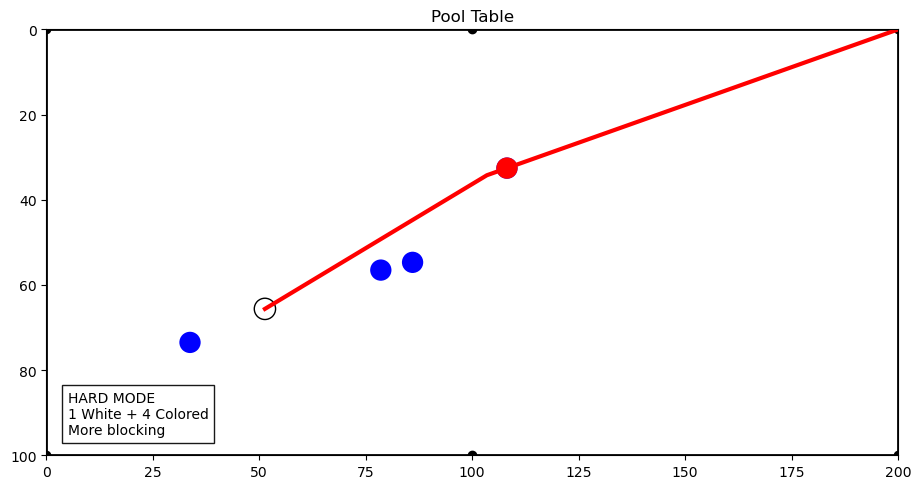

In [1]:
import math
import random
import tkinter as tk
from tkinter import ttk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# =========================
# CONFIG
# =========================
TABLE_W, TABLE_H = 200, 100
BALL_R = 2.5
MAX_CUT_ANGLE = 65

POCKETS = {
    "TL": (0, 0), "TM": (100, 0), "TR": (200, 0),
    "BL": (0, 100), "BM": (100, 100), "BR": (200, 100)
}

SCENARIO = {
    "EASY": 1,
    "NORMAL": 2,
    "HARD": 3,
    "CUSTOM": 4
}

SCENARIO_TEXT = {
    SCENARIO["EASY"]:
        "EASY MODE\nClick WHITE → Click COLORED",

    SCENARIO["NORMAL"]:
        "NORMAL MODE\n1 White + 3 Colored\nClick a colored ball",

    SCENARIO["HARD"]:
        "HARD MODE\n1 White + 4 Colored\nMore blocking",

    SCENARIO["CUSTOM"]:
        "CUSTOM MODE\nPlace WHITE then COLORED\nDouble-click to select"
}

# =========================
# GEOMETRY
# =========================
def dist(a, b):
    return math.hypot(a[0]-b[0], a[1]-b[1])

def angle_between(v1, v2):
    dot = v1[0]*v2[0] + v1[1]*v2[1]
    m1 = math.hypot(*v1)
    m2 = math.hypot(*v2)
    if m1 == 0 or m2 == 0:
        return 180
    return math.degrees(math.acos(max(-1, min(1, dot/(m1*m2)))))

def segment_hits_ball(a, b, c):
    ax, ay = a
    bx, by = b
    cx, cy = c
    lab = dist(a, b)
    if lab == 0:
        return False
    t = ((cx-ax)*(bx-ax) + (cy-ay)*(by-ay)) / lab**2
    t = max(0, min(1, t))
    px = ax + t*(bx-ax)
    py = ay + t*(by-ay)
    return dist((px, py), c) < BALL_R*2

# =========================
# SHOT LOGIC
# =========================
def compute_shots(white, target, blockers):
    shots = []
    for pname, pocket in POCKETS.items():
        vx, vy = pocket[0]-target[0], pocket[1]-target[1]
        d = math.hypot(vx, vy)
        if d == 0:
            continue

        ghost = (
            target[0] - vx/d * BALL_R*2,
            target[1] - vy/d * BALL_R*2
        )

        cut = angle_between(
            (ghost[0]-white[0], ghost[1]-white[1]),
            (pocket[0]-target[0], pocket[1]-target[1])
        )

        if cut > MAX_CUT_ANGLE:
            continue

        if any(
            segment_hits_ball(white, ghost, b) or
            segment_hits_ball(target, pocket, b)
            for b in blockers
        ):
            continue

        score = cut + dist(white, ghost)*0.02
        shots.append({"score": score, "path": [white, ghost, pocket], "pocket": pname})

    return sorted(shots, key=lambda s: s["score"])[:2]

# =========================
# STATE
# =========================
white = None
colored = []
selected = None
click_history = []
current_scenario = None

# =========================
# TKINTER WINDOW
# =========================
root = tk.Tk()
root.title("Pool AI – Scenario Trainer")
root.geometry("1200x650")

# =========================
# MATPLOTLIB FIGURE
# =========================
fig, ax = plt.subplots(figsize=(9, 5))
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

# =========================
# DRAW
# =========================
def redraw():
    ax.clear()
    ax.set_xlim(0, TABLE_W)
    ax.set_ylim(TABLE_H, 0)
    ax.set_aspect("equal")
    ax.set_title("Pool Table")

    ax.add_patch(plt.Rectangle((0,0), TABLE_W, TABLE_H, fill=False, linewidth=2))

    for p in POCKETS.values():
        ax.plot(*p, "ko")

    if white:
        ax.add_patch(plt.Circle(white, BALL_R, fc="white", ec="black"))

    for b in colored:
        ax.add_patch(plt.Circle(b, BALL_R, fc="blue"))

    if selected:
        ax.add_patch(plt.Circle(selected, BALL_R, fc="red"))

    if white and selected:
        shots = compute_shots(white, selected, [b for b in colored if b != selected])
        colors = ["red", "orange"]
        for i, s in enumerate(shots):
            xs = [p[0] for p in s["path"]]
            ys = [p[1] for p in s["path"]]
            ax.plot(xs, ys, color=colors[i], linewidth=3)

    if current_scenario:
        ax.text(5, 95, SCENARIO_TEXT[current_scenario],
                bbox=dict(facecolor="white", alpha=0.9))

    canvas.draw()

# =========================
# CLICK HANDLER
# =========================
def on_click(event):
    global white, selected
    if event.inaxes != ax or not current_scenario:
        return

    pos = (event.xdata, event.ydata)

    if current_scenario == SCENARIO["EASY"]:
        if not white:
            white = pos
        elif not selected:
            selected = pos

    elif current_scenario in (SCENARIO["NORMAL"], SCENARIO["HARD"]):
        for b in colored:
            if dist(pos, b) < BALL_R*2:
                selected = b

    elif current_scenario == SCENARIO["CUSTOM"]:
        if not white:
            white = pos
        elif len(colored) < 4:
            colored.append(pos)
        else:
            for b in colored:
                if dist(pos, b) < BALL_R*2:
                    click_history.append(b)
                    if click_history.count(b) == 2:
                        selected = b

    redraw()

canvas.mpl_connect("button_press_event", on_click)

# =========================
# SCENARIO SETUP
# =========================
def setup_scenario(s):
    global white, colored, selected, click_history, current_scenario
    white, colored, selected = None, [], None
    click_history.clear()
    current_scenario = s

    if s in (SCENARIO["NORMAL"], SCENARIO["HARD"]):
        white = (random.uniform(30,170), random.uniform(20,80))
        n = 3 if s == SCENARIO["NORMAL"] else 4
        for _ in range(n):
            colored.append((random.uniform(30,170), random.uniform(20,80)))

    redraw()

# =========================
# CONTROL PANEL
# =========================
panel = tk.Frame(root, padx=10)
panel.pack(side=tk.RIGHT, fill=tk.Y)

tk.Label(panel, text="Scenario", font=("Arial", 14)).pack(pady=10)

ttk.Button(panel, text="EASY", command=lambda: setup_scenario(SCENARIO["EASY"])).pack(fill="x")
ttk.Button(panel, text="NORMAL", command=lambda: setup_scenario(SCENARIO["NORMAL"])).pack(fill="x")
ttk.Button(panel, text="HARD", command=lambda: setup_scenario(SCENARIO["HARD"])).pack(fill="x")
ttk.Button(panel, text="CUSTOM", command=lambda: setup_scenario(SCENARIO["CUSTOM"])).pack(fill="x")

# =========================
# START
# =========================
redraw()
root.mainloop()


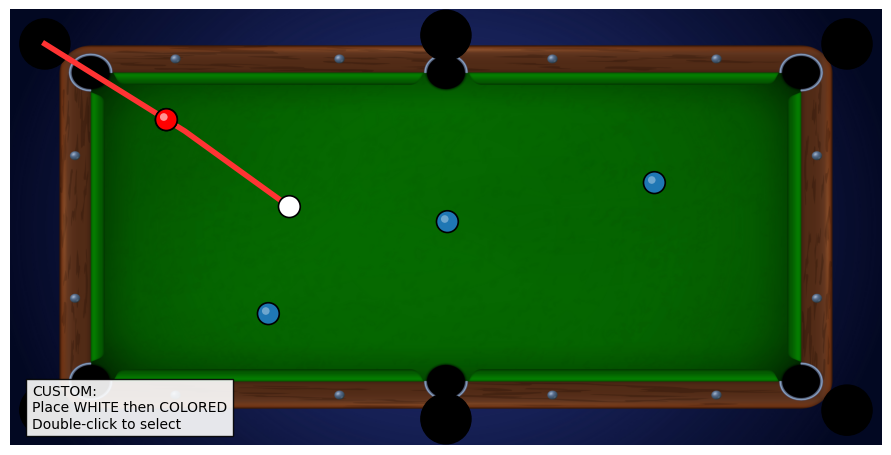

In [4]:
import math
import random
import os
import tkinter as tk
from tkinter import ttk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# =========================
# CONFIG
# =========================
TABLE_W, TABLE_H = 200, 100
BALL_R = 2.5
MAX_CUT_ANGLE = 65

TABLE_IMAGE = "pool_table.jpeg"
if not os.path.exists(TABLE_IMAGE):
    raise FileNotFoundError("pool_table.png not found in project folder")

POCKETS = {
    "TL": (8, 8), "TM": (100, 6), "TR": (192, 8),
    "BL": (8, 92), "BM": (100, 94), "BR": (192, 92)
}

SCENARIO = {
    "EASY": 1,
    "NORMAL": 2,
    "HARD": 3,
    "CUSTOM": 4
}

SCENARIO_TEXT = {
    SCENARIO["EASY"]:   "EASY:\nClick WHITE → Click COLORED",
    SCENARIO["NORMAL"]: "NORMAL:\n1 White + 3 Colored\nClick a colored ball",
    SCENARIO["HARD"]:   "HARD:\n1 White + 4 Colored\nMore blocking",
    SCENARIO["CUSTOM"]: "CUSTOM:\nPlace WHITE then COLORED\nDouble-click to select"
}

# =========================
# GEOMETRY
# =========================
def dist(a, b):
    return math.hypot(a[0]-b[0], a[1]-b[1])

def angle_between(v1, v2):
    dot = v1[0]*v2[0] + v1[1]*v2[1]
    m1 = math.hypot(*v1)
    m2 = math.hypot(*v2)
    if m1 == 0 or m2 == 0:
        return 180
    return math.degrees(math.acos(max(-1, min(1, dot/(m1*m2)))))

def segment_hits_ball(a, b, c):
    ax, ay = a
    bx, by = b
    cx, cy = c
    lab = dist(a, b)
    if lab == 0:
        return False
    t = ((cx-ax)*(bx-ax) + (cy-ay)*(by-ay)) / lab**2
    t = max(0, min(1, t))
    px = ax + t*(bx-ax)
    py = ay + t*(by-ay)
    return dist((px, py), c) < BALL_R*2

# =========================
# SHOT LOGIC (DIRECT)
# =========================
def compute_shots(white, target, blockers):
    shots = []
    for pname, pocket in POCKETS.items():
        vx, vy = pocket[0]-target[0], pocket[1]-target[1]
        d = math.hypot(vx, vy)
        if d == 0:
            continue

        ghost = (
            target[0] - vx/d * BALL_R*2,
            target[1] - vy/d * BALL_R*2
        )

        cut = angle_between(
            (ghost[0]-white[0], ghost[1]-white[1]),
            (pocket[0]-target[0], pocket[1]-target[1])
        )

        if cut > MAX_CUT_ANGLE:
            continue

        if any(
            segment_hits_ball(white, ghost, b) or
            segment_hits_ball(target, pocket, b)
            for b in blockers
        ):
            continue

        score = cut + dist(white, ghost)*0.02
        shots.append({"score": score, "path": [white, ghost, pocket], "pocket": pname})

    return sorted(shots, key=lambda s: s["score"])[:2]

# =========================
# STATE
# =========================
white = None
colored = []
selected = None
click_history = []
current_scenario = None

# =========================
# TKINTER WINDOW
# =========================
root = tk.Tk()
root.title("Pool AI – Realistic Trainer")
root.geometry("1250x680")

# =========================
# MATPLOTLIB
# =========================
fig, ax = plt.subplots(figsize=(9.5, 5))
table_img = plt.imread(TABLE_IMAGE)

canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

# =========================
# DRAW HELPERS
# =========================
def draw_ball(pos, color):
    ax.add_patch(plt.Circle(pos, BALL_R, fc=color, ec="black", linewidth=1.2, zorder=5))
    ax.add_patch(plt.Circle((pos[0]-0.6, pos[1]-0.6),
                            BALL_R*0.35, fc="white", alpha=0.35, zorder=6))

# =========================
# DRAW
# =========================
def redraw():
    ax.clear()
    ax.set_xlim(0, TABLE_W)
    ax.set_ylim(TABLE_H, 0)
    ax.set_aspect("equal")
    ax.axis("off")

    ax.imshow(table_img, extent=[0, TABLE_W, TABLE_H, 0], zorder=0)

    for p in POCKETS.values():
        ax.add_patch(plt.Circle(p, BALL_R*2.3, color="black", zorder=3))

    if white:
        draw_ball(white, "white")

    for b in colored:
        draw_ball(b, "#1f77b4")

    if selected:
        draw_ball(selected, "red")

    if white and selected:
        shots = compute_shots(white, selected, [b for b in colored if b != selected])
        colors = ["#ff3333", "#ffaa00"]
        for i, s in enumerate(shots):
            xs = [p[0] for p in s["path"]]
            ys = [p[1] for p in s["path"]]
            ax.plot(xs, ys, color=colors[i], linewidth=4, zorder=4)

    if current_scenario:
        ax.text(5, 96, SCENARIO_TEXT[current_scenario],
                fontsize=10,
                bbox=dict(facecolor="white", alpha=0.9))

    canvas.draw()

# =========================
# CLICK HANDLER
# =========================
def on_click(event):
    global white, selected
    if event.inaxes != ax or not current_scenario:
        return

    pos = (event.xdata, event.ydata)

    if current_scenario == SCENARIO["EASY"]:
        if not white:
            white = pos
        elif not selected:
            selected = pos

    elif current_scenario in (SCENARIO["NORMAL"], SCENARIO["HARD"]):
        for b in colored:
            if dist(pos, b) < BALL_R*2:
                selected = b

    elif current_scenario == SCENARIO["CUSTOM"]:
        if not white:
            white = pos
        elif len(colored) < 4:
            colored.append(pos)
        else:
            for b in colored:
                if dist(pos, b) < BALL_R*2:
                    click_history.append(b)
                    if click_history.count(b) == 2:
                        selected = b

    redraw()

canvas.mpl_connect("button_press_event", on_click)

# =========================
# SCENARIO SETUP
# =========================
def setup_scenario(s):
    global white, colored, selected, click_history, current_scenario
    white, colored, selected = None, [], None
    click_history.clear()
    current_scenario = s

    if s in (SCENARIO["NORMAL"], SCENARIO["HARD"]):
        white = (random.uniform(40,160), random.uniform(25,75))
        n = 3 if s == SCENARIO["NORMAL"] else 4
        for _ in range(n):
            colored.append((random.uniform(40,160), random.uniform(25,75)))

    redraw()

# =========================
# CONTROL PANEL
# =========================
panel = tk.Frame(root, padx=10)
panel.pack(side=tk.RIGHT, fill=tk.Y)

tk.Label(panel, text="SCENARIO", font=("Arial", 14, "bold")).pack(pady=10)

ttk.Button(panel, text="EASY", command=lambda: setup_scenario(SCENARIO["EASY"])).pack(fill="x", pady=4)
ttk.Button(panel, text="NORMAL", command=lambda: setup_scenario(SCENARIO["NORMAL"])).pack(fill="x", pady=4)
ttk.Button(panel, text="HARD", command=lambda: setup_scenario(SCENARIO["HARD"])).pack(fill="x", pady=4)
ttk.Button(panel, text="CUSTOM", command=lambda: setup_scenario(SCENARIO["CUSTOM"])).pack(fill="x", pady=4)

# =========================
# START
# =========================
redraw()
root.mainloop()
